# Preprocessing

In [17]:
# IMPORT LIBRARY
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# LOAD DATASETS
train = pd.read_csv(r"recipe_train.csv",index_col=False,delimiter=",")
test = pd.read_csv(r"recipe_test.csv",index_col=False, delimiter=",")

# SEPERATE DATA & TARGET
train_data = train.iloc[:,:-1]
train_target = train['duration_label']

# DELETE ingredients
del train_data['ingredients']
del test['ingredients']

print(train_data.shape)
print(test.shape)

# SPLIT DATASET
x_train, x_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.25, random_state=0)

column_transformer = ColumnTransformer([('name_bow', CountVectorizer(stop_words='english'), 'name'),
                                 ('steps_bow', CountVectorizer(stop_words='english',ngram_range = (1,2)), 'steps')],
                                 remainder = MinMaxScaler())

# COLUMN TRANSFORMER
model = column_transformer.fit(x_train)
x_train_model = model.transform(x_train)
print(x_train_model.shape)
x_test_model = model.transform(x_test)
print(x_test_model.shape)
real_test_model = model.transform(test)

# FILTER FEATURES BY VARIANCETHRESHOLD
selector = VarianceThreshold(threshold=0.001)
x_var_train = selector.fit_transform(x_train_model)
print(x_var_train.shape)
x_var_test = selector.transform(x_test_model)
print(x_var_test.shape)
x_var_real_test = selector.transform(real_test_model)

# FEATURE SELECTION
k = 5200

# CHI_SQUARE
x2 = SelectKBest(chi2,k=k)
X_train_x2 = x2.fit_transform(x_var_train,y_train)
X_test_x2 = x2.transform(x_var_test)
# Real-TEST
X_real_test_x2 = x2.transform(x_var_real_test)
print(X_train_x2.shape)
print(X_test_x2.shape)

(40000, 4)
(10000, 4)
(30000, 370840)
(10000, 370840)
(30000, 10692)
(10000, 10692)
(30000, 5200)
(10000, 5200)


# 0-R Classifier

In [2]:
# BASELINE MODEL: DUMMY CLASSIFIER
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent')
model = clf.fit(train.iloc[:,:-1], train['duration_label'])
print("Baseline Accuracy:",model.score(train.iloc[:,:-1], train['duration_label']))

Baseline Accuracy: 0.50615


# Distribution of Labels

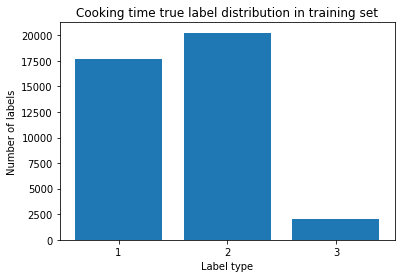

2.0    20246
1.0    17705
3.0     2049
Name: duration_label, dtype: int64

In [3]:
import matplotlib.pyplot as plt

train_target.value_counts()

Label = ['1','2','3']
data = [train_target.value_counts()[1],train_target.value_counts()[2],train_target.value_counts()[3]]

plt.bar(Label, data)
plt.title('Cooking time true label distribution in training set')
plt.xlabel('Label type')
plt.ylabel('Number of labels')
plt.show()

train_target.value_counts()

# Multinomial Logistic Regression

In [4]:
# Multinomial LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
# record time
t0 = time.time()

# LOGISTIC REGRESSION
lr = LogisticRegression(solver='sag',multi_class='multinomial',C=0.006,random_state=0).fit(X_train_x2,y_train)
lr_title = 'Logistic Regression'
lr_acc = np.mean(cross_val_score(lr,X_test_x2,y_test,cv=5))

t1 = time.time() - t0
print("Execution time of logistic regression classifier: {} s".format(round(t1,3)) )

print('Testing accuracy:',lr_title, lr_acc)

y_train_predicted = lr.predict(X_train_x2)
print('Training accuracy: ',np.mean(y_train_predicted == y_train))
print('Mean Absolute Error of Training:', metrics.mean_absolute_error(y_train, y_train_predicted))
print('Mean Squared Error of Training:', metrics.mean_squared_error(y_train, y_train_predicted))
print('Root Mean Squared Error of Training:', np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted)))

y_pred = lr.predict(X_test_x2)
print('Mean Absolute Error of Testing:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error of Testing:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error of Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# PREDICT LABEL
LR_label = lr.predict(X_real_test_x2)
print(LR_label.shape)

# Compute Macro metrics of the classifier
precision = precision_score(y_test, y_pred,average = "macro")
print('Macro Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average = "macro")
print('Macro Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred,average = "macro")
print('Macro F1 score: %f' % f1)

# Compute Weighted metrics of the classifier
precision = precision_score(y_test, y_pred,average = "weighted")
print('Weighted Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average = "weighted")
print('Weighted Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average = "weighted")
print('Weighted F1 score: %f' % f1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Execution time of logistic regression classifier: 8.699 s
Testing accuracy: Logistic Regression 0.7886
Training accuracy:  0.8078666666666666
Mean Absolute Error of Training: 0.2054
Mean Squared Error of Training: 0.23193333333333332
Root Mean Squared Error of Training: 0.48159457361284014
Mean Absolute Error of Testing: 0.2261
Mean Squared Error of Testing: 0.2543
Root Mean Squared Error of Testing: 0.5042816673249187
(10000,)
Macro Precision: 0.787192
Macro Recall: 0.726076
Macro F1 score: 0.751499
Weighted Precision: 0.787855
Weighted Recall: 0.788000
Weighted F1 score: 0.787051


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# Prediction of Multinomial Logistic Regression

In [5]:
# WRITE OUTPUT
id_list = []
for i in range(1,len(test)+1):
    id_list.append(i)
output=pd.DataFrame({'id':id_list,'duration_label':LR_label})
output.to_csv('MLR_Prediction.csv', sep=',', header=True, index=False)

# ROC/AUC of Logistic Regression

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


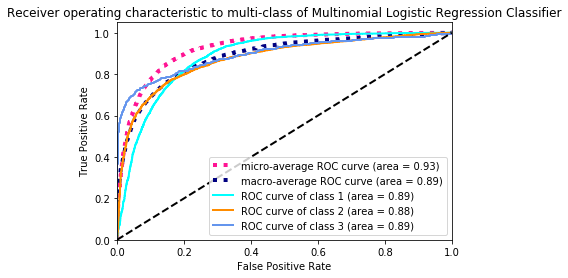

In [6]:
## Plot the ROC curve for Logistic Regression

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

y_train_bin = label_binarize(y_train, classes=[1, 2, 3])
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
n_classes = 3

classifier = OneVsRestClassifier(lr)
y_score = classifier.fit(X_train_x2, y_train).decision_function(X_test_x2)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i].ravel(), y_score[:, i].ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])   

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
lw = 2
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class of Multinomial Logistic Regression Classifier')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix of Logistic Regression

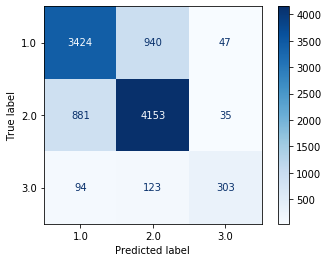

In [7]:
# CONFUSION MATRIX
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr, X_test_x2, y_test,cmap=plt.cm.Blues)

# Random Forest

In [8]:
# RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

t0 = time.time()
rf = RandomForestClassifier(n_estimators=400,min_samples_split=2,min_samples_leaf=1, max_features='sqrt',
                            max_depth=None, bootstrap=True, random_state = 42)
rf_model = rf.fit(X_train_x2, y_train)
rf_acc = np.mean(cross_val_score(rf_model,X_test_x2,y_test,cv=5))

t1 = time.time() - t0
print("Execution time of Random Forest classifier: {} s".format(round(t1,3)) )

rf_title = 'Random Forest'
print('Testing accuracy:',rf_title, rf_acc)

y_train_predicted = rf_model.predict(X_train_x2)
print('Training accuracy: ',np.mean(y_train_predicted == y_train))
print('Mean Absolute Error of Training:', metrics.mean_absolute_error(y_train, y_train_predicted))
print('Mean Squared Error of Training:', metrics.mean_squared_error(y_train, y_train_predicted))
print('Root Mean Squared Error of Training:', np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted)))

y_pred = rf_model.predict(X_test_x2)
print('Mean Absolute Error of Testing:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error of Testing:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error of Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RF_label = rf_model.predict(X_real_test_x2)
print('The similarity in predicted labels between RF & LR :',np.mean(RF_label == LR_label))

# Compute Macro metrics of the classifier
precision = precision_score(y_test, y_pred,average = "macro")
print('Macro Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average = "macro")
print('Macro Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred,average = "macro")
print('Macro F1 score: %f' % f1)

# Compute Weighted metrics of the classifier
precision = precision_score(y_test, y_pred,average = "weighted")
print('Weighted Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average = "weighted")
print('Weighted Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average = "weighted")
print('Weighted F1 score: %f' % f1)

Execution time of Random Forest classifier: 314.942 s
Testing accuracy: Random Forest 0.7933
Training accuracy:  0.9999666666666667
Mean Absolute Error of Training: 3.3333333333333335e-05
Mean Squared Error of Training: 3.3333333333333335e-05
Root Mean Squared Error of Training: 0.005773502691896258
Mean Absolute Error of Testing: 0.2074
Mean Squared Error of Testing: 0.2298
Root Mean Squared Error of Testing: 0.47937459256827536
The similarity in predicted labels between RF & LR : 0.865
Macro Precision: 0.850432
Macro Recall: 0.711207
Macro F1 score: 0.756673
Weighted Precision: 0.807582
Weighted Recall: 0.803800
Weighted F1 score: 0.801614


# Prediction of Random Forest

In [9]:
# WRITE OUTPUT
id_list = []
for i in range(1,len(test)+1):
    id_list.append(i)
output=pd.DataFrame({'id':id_list,'duration_label':RF_label})
output.to_csv('RF_Prediction.csv', sep=',', header=True, index=False)

# ROC/AUC of Random Forest

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


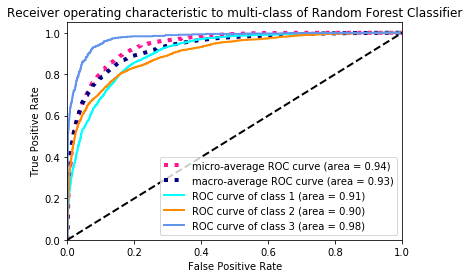

In [10]:
## Plot the ROC curve for Random Forest

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

classifier = OneVsRestClassifier(rf)
y_score = classifier.fit(X_train_x2, y_train).predict_proba(X_test_x2)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i].ravel(), y_score[:, i].ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])   

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
lw = 2
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class of Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix of Random Forest

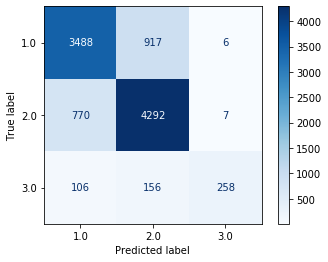

In [12]:
# CONFUSION MATRIX
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf_model, X_test_x2, y_test,cmap=plt.cm.Blues)

# Light GBM

In [13]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

t0 = time.time()
lgb_model =  lgb.LGBMClassifier(boosting_type='dart',
                         objective = 'multiclass',
                         verbose = 0,
                         num_iterations = 415,
                         learning_rate = 0.085,
                         n_estimators = 200,
                         max_bin = 50,
                         num_leaves = 80,
                         max_depth = 10,
                         feature_fraction=0.68,
                         bagging_fraction= 0.85,
                         bagging_freq= 8,
                         lambda_l1= 0.6,
                         lambda_l2= 0,
                         early_stopping_rounds=1)

lgb_model.fit(X_train_x2, y_train)
y_pred=lgb_model.predict(X_test_x2)
lgb_acc  = np.mean(cross_val_score(lgb_model,X_test_x2,y_test,cv=5))

t1 = time.time() - t0
print("Execution time of LightGBM classifier: {} s".format(round(t1,3)) )

print('LightGBM Model accuracy score: {0:0.4f}'.format(lgb_acc))

y_train_predicted = lgb_model.predict(X_train_x2)
print('Training accuracy: ',np.mean(y_train_predicted == y_train))
print('Mean Absolute Error of Training:', metrics.mean_absolute_error(y_train, y_train_predicted))
print('Mean Squared Error of Training:', metrics.mean_squared_error(y_train, y_train_predicted))
print('Root Mean Squared Error of Training:', np.sqrt(metrics.mean_squared_error(y_train, y_train_predicted)))

y_pred = lgb_model.predict(X_test_x2)
print('Mean Absolute Error of Testing:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error of Testing:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error of Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

LGB_label = lgb_model.predict(X_real_test_x2)
print('The similarity in predicted labels between LGBM & LR :',np.mean(LGB_label == LR_label))
print('The similarity in predicted labels between LGBM & RF :',np.mean(LGB_label == RF_label))

# Compute Macro metrics of the classifier
precision = precision_score(y_test, y_pred,average = "macro")
print('Macro Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average = "macro")
print('Macro Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred,average = "macro")
print('Macro F1 score: %f' % f1)

# Compute Weighted metrics of the classifier
precision = precision_score(y_test, y_pred,average = "weighted")
print('Weighted Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average = "weighted")
print('Weighted Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average = "weighted")
print('Weighted F1 score: %f' % f1)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.68
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: f

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.68
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: f

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.68
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: f

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.68
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: f

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.68
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: f

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.68
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: f

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

# Prediction of Light GBM

In [15]:
# WRITE OUTPUT
id_list = []
for i in range(1,len(test)+1):
    id_list.append(i)
output=pd.DataFrame({'id':id_list,'duration_label':LGB_label})
output.to_csv('LGB_Prediction.csv', sep=',', header=True, index=False)

# ROC/AUC of Light GBM

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.68
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: fea

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


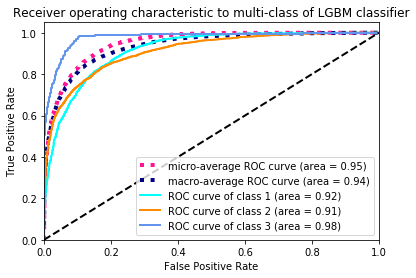

In [18]:
## Plot the ROC curve for LGBM

y_score = lgb_model.fit(X_train_x2, y_train).predict_proba(X_test_x2)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i].ravel(), y_score[:, i].ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])   

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
lw = 2
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class of LGBM classifier')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix of Light GBM

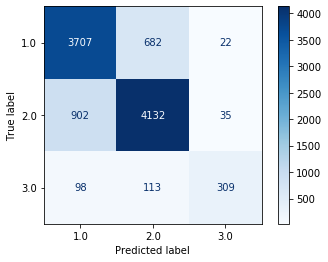

In [19]:
# CONFUSION MATRIX
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lgb_model, X_test_x2, y_test,cmap=plt.cm.Blues)

# Stacking

In [21]:
# Stacking
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier

t0 = time.time()
estimators = [ ('rf', RandomForestClassifier(n_estimators=400,min_samples_split=2,min_samples_leaf=1, max_features='sqrt',max_depth=None, bootstrap=True,random_state = 42)),    
              ('lr', LogisticRegression(solver='sag',multi_class='multinomial',C=0.006)) ]

clf = StackingClassifier(estimators = estimators, final_estimator=
                         lgb.LGBMClassifier(boosting_type='dart',objective = 'multiclass',num_classes = 3,verbose = 0,
                                            num_iterations = 415, learning_rate = 0.085,n_estimators = 200,
                                            max_bin = 400, num_leaves = 80, max_depth = 10,feature_fraction=0.68,
                                            bagging_fraction= 0.9, bagging_freq= 8,lambda_l1= 0.6,lambda_l2= 0,early_stopping_rounds=1))

clf.fit(X_train_x2, y_train)

y_pred = clf.predict(X_test_x2)
t1 = time.time() - t0
print("Execution time of Stacking classifier: {} s".format(round(t1,3)) )

print('\nStacker Accuracy (LGBM):', clf.score(X_test_x2, y_test))
print('Mean Absolute Error of Testing:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error of Testing:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error of Testing:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Stacking_label = clf.predict(X_real_test_x2)
print(Stacking_label.shape)

# Compute Macro metrics of the classifier
precision = precision_score(y_test, y_pred,average = "macro")
print('Macro Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average = "macro")
print('Macro Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred,average = "macro")
print('Macro F1 score: %f' % f1)

# Compute Weighted metrics of the classifier
precision = precision_score(y_test, y_pred,average = "weighted")
print('Weighted Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average = "weighted")
print('Weighted Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average = "weighted")
print('Weighted F1 score: %f' % f1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did 

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.68
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: fea

# Prediction of Stacking

In [22]:
# WRITE OUTPUT
id_list = []
for i in range(1,len(test)+1):
    id_list.append(i)
output=pd.DataFrame({'id':id_list,'duration_label':Stacking_label})
output.to_csv('Stacking_Prediction.csv', sep=',', header=True, index=False)

# ROC/AUC of Stacking

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did 

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.68
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: fea

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


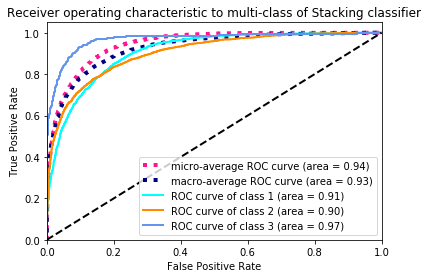

In [23]:
## Plot the ROC curve for Stacker

y_score = clf.fit(X_train_x2, y_train).predict_proba(X_test_x2)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i].ravel(), y_score[:, i].ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])   

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
lw = 2
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class of Stacking classifier')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix of Stacking

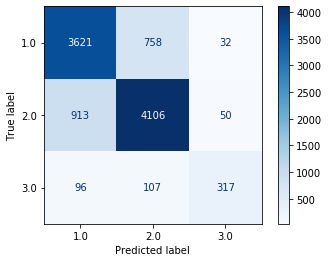

In [24]:
# CONFUSION MATRIX
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test_x2, y_test,cmap=plt.cm.Blues)

# Error Analysis of Random Forest

In [25]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()
random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200,300,400]}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_x2, y_train)
print(rf_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


Testing accuracy: Random Forest 0.7935000000000001


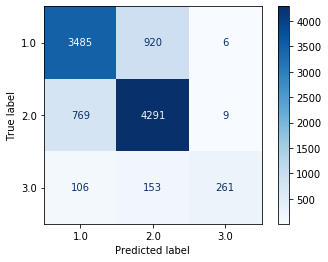

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

rf = RandomForestClassifier(n_estimators=400,min_samples_split=5,min_samples_leaf=1, max_features='sqrt',
                            max_depth=None, bootstrap=False, random_state = 42)
rf_model = rf.fit(X_train_x2, y_train)
rf_acc = np.mean(cross_val_score(rf_model,X_test_x2,y_test,cv=5))

rf_title = 'Random Forest'
print('Testing accuracy:',rf_title, rf_acc)

# CONFUSION MATRIX
plot_confusion_matrix(rf_model, X_test_x2, y_test,cmap=plt.cm.Blues)

# Error Analysis of Multinomial Logistic Regression

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Testing accuracy: Logistic Regression 0.76825


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


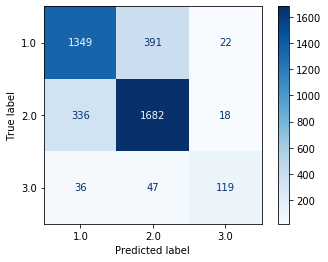

In [27]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import time

# SPLIT DATASET
x_train, x_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.1, random_state=0)

column_transformer = ColumnTransformer([('name_bow', CountVectorizer(stop_words='english'), 'name'),
                                 ('steps_bow', CountVectorizer(stop_words='english',ngram_range = (1,2)), 'steps')],
                                 remainder = MinMaxScaler())

# COLUMN TRANSFORMER
model = column_transformer.fit(x_train)
x_train_model = model.transform(x_train)
x_test_model = model.transform(x_test)
real_test_model = model.transform(test)

# FILTER FEATURES BY VARIANCETHRESHOLD
selector = VarianceThreshold(threshold=0.001)
x_var_train = selector.fit_transform(x_train_model)
x_var_test = selector.transform(x_test_model)
x_var_real_test = selector.transform(real_test_model)

# FEATURE SELECTION
k = 5200

# CHI_SQUARE
x2 = SelectKBest(chi2,k=k)
X_train_x2 = x2.fit_transform(x_var_train,y_train)
X_test_x2 = x2.transform(x_var_test)
# Real-TEST
X_real_test_x2 = x2.transform(x_var_real_test)

# LOGISTIC REGRESSION
lr = LogisticRegression(solver='sag',multi_class='multinomial',C=0.006).fit(X_train_x2,y_train)
lr_title = 'Logistic Regression'
lr_acc = np.mean(cross_val_score(lr,X_test_x2,y_test,cv=5))
print('Testing accuracy:',lr_title, lr_acc)

# CONFUSION MATRIX
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr, X_test_x2, y_test,cmap=plt.cm.Blues)

# Kaggle Best Accuracy Code Section

### We use a validation set before to find the best-performing model and its hyperparameters. Now, we cancel the validation set and uses the full training data to train the previous best-performing model to achieve the highest accuracy in Kaggle

In [28]:
column_transformer = ColumnTransformer([('name_bow', CountVectorizer(stop_words='english'), 'name'),
                                 ('steps_bow', CountVectorizer(stop_words='english',ngram_range = (1,2)), 'steps')],
                                 remainder = MinMaxScaler())

# COLUMN TRANSFORMER
model = column_transformer.fit(train_data)
x_train_model = model.transform(train_data)
print(x_train_model.shape)
real_test_model = model.transform(test)

# FILTER FEATURES BY VARIANCETHRESHOLD
selector = VarianceThreshold(threshold=0.001)
x_var_train = selector.fit_transform(x_train_model)
print(x_var_train.shape)
x_var_real_test = selector.transform(real_test_model)

# FEATURE SELECTION
k = 5200

# CHI_SQUARE
x2 = SelectKBest(chi2,k=k)
X_train_x2 = x2.fit_transform(x_var_train,train_target)
# Real-TEST
X_real_test_x2 = x2.transform(x_var_real_test)
print(X_train_x2.shape)

lgb_model =  lgb.LGBMClassifier(boosting_type='dart',
                         objective = 'multiclass',
                         verbose = 0,
                         num_iterations = 415,
                         learning_rate = 0.085,
                         n_estimators = 200,
                         max_bin = 60,
                         num_leaves = 80,
                         max_depth = 10,
                         feature_fraction=0.68,
                         bagging_fraction= 0.9,
                         bagging_freq= 8,
                         lambda_l1= 0.6,
                         lambda_l2= 0,
                         early_stopping_rounds=1)

lgb_model.fit(X_train_x2, train_target)

y_train_predicted = lgb_model.predict(X_train_x2)
print('Training accuracy: ',np.mean(y_train_predicted == train_target))

LGB_label = lgb_model.predict(X_real_test_x2)

# WRITE OUTPUT
id_list = []
for i in range(1,len(test)+1):
    id_list.append(i)
output=pd.DataFrame({'id':id_list,'duration_label':LGB_label})
output.to_csv('Best_Prediction.csv', sep=',', header=True, index=False)

(40000, 445874)
(40000, 10706)
(40000, 5200)
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.68
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] early_stopping_round is set=1, early_stopping_rounds=1 will be ignored. Current value: early_stopping_round=1


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.68, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.68
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.316524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f